In [1]:
%pylab inline 
%config InlineBackend.figure_format = 'retina'
import pickle 
import seaborn as sns
from bigfile import BigFile 
from scipy.optimize import fsolve
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
h = 0.697    # Hubble:   WMAP 9yr
L = 400./h   # Box size: Mpc
V = L**3     # Volume:   Mpc^3

# class: GlobalQuantityBlueTides
get PIG data from Yu's directory

In [4]:
class GlobalQuantityBlueTides:
    
    pigs = ['/home/yfeng1/bluetide/PIG_086/', 
            '/home/yfeng1/bluetide/PIG_066/',
            '/home/yfeng1/bluetide/PIG_054/', 
            '/home/yfeng1/bluetide/PIG_048/', 
            '/home/yfeng1/bluetide/PIG_044/']

    def __init__(self, redshift):
        self.redshift  = redshift
        
    def blackholemass_nonzerofofidx(self):
        pigidx = int(self.redshift-8)      # index of pigs list
        pig = BigFile(self.pigs[pigidx])
        blackholemass = pig.open('FOFGroups/BlackholeMass')
        blackholemass = blackholemass[:]
        nonzerofofidx = blackholemass > 0
        return nonzerofofidx
    
    def read_data(self, block, particletype=-1):            # input block string
        pigidx = int(self.redshift-8)      # index of pigs list
        pig = BigFile(self.pigs[pigidx])
        bluetidesdata = pig.open(block)
        if particletype==-1:
            bluetidesdata = bluetidesdata[:]
        elif particletype!=-1:
            bluetidesdata = bluetidesdata[:][:,particletype]
        else:
            print('wrong particletype!!!')
        condition = self.blackholemass_nonzerofofidx()
        bluetidesdata = bluetidesdata[condition]
        return bluetidesdata

In [5]:
bluetides = [GlobalQuantityBlueTides(uu) for uu in range(8,13)]

In [6]:
blackholemass = np.array([bluetides[uu].read_data('FOFGroups/BlackholeMass') for uu in range(0,5)])*1e10/h
accretionrate = np.array([bluetides[uu].read_data('FOFGroups/BlackholeAccretionRate') for uu in range(0,5)])*10.2
sfr           = np.array([bluetides[uu].read_data('FOFGroups/StarFormationRate') for uu in range(0,5)])
stellarmass   = np.array([bluetides[uu].read_data('FOFGroups/MassByType',particletype=4) for uu in range(0,5)])*1e10/h

# Parameters

In [7]:
bhlowercut = 1.5e6    # bh mass cut
smlowercut = 1e8      # stellar mass cut
Lx_arr = np.array([10**42.5,10**43.0])    # Lx cut

In [8]:
labelfontsize = 18
tickfontsize = 16
annotate = 14

# Bolometric luminosity

In [9]:
def basic_fig_set():
    sns.set_style("white")
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(7, 6, forward=True)

In [10]:
def acc_rate_to_bolometric(accretionrate):
    
    accretionrate = accretionrate.astype(float64)
    c     = 3e8
    unit  = 2e30/365/86400  # convert Msun/yr into kg/s
    Lbol  = 0.1*c**2*accretionrate*unit  # J/s
    Lbol *= 1e7
    
    return Lbol

In [11]:
# above_below: 1 above, 0 below

def select_data_cut( target_arr, con_arr, con_val, above_below ):
    
    if above_below == 1 :
        con = con_arr > con_val
    elif above_below == 0 :
        con = con_arr < con_val
    else:
        print('NOOOOOOO: above_below is incorrect...')
    
    return target_arr[con]

In [12]:
def plot_mean_Edd_line(accretionrate,blackholemass):
    M_Edd = np.logspace(6,9)
    lambda_Edd = accretionrate/(blackholemass*2.2e-8)
    mean_Edd = np.mean(lambda_Edd)
    L_mean_Edd = 10**( 38.11 + np.log10(mean_Edd) + np.log10(M_Edd) )
    loglog(M_Edd, L_mean_Edd, color='#B3EE3A', linewidth=3, label=r'$L_B(\overline{\lambda}_{Edd}=%.1f)$'%mean_Edd)
#     loglog(M_Edd, L_mean_Edd, color='#B3EE3A', linewidth=3, label=r'$L_{\overline{\lambda}_{Edd}=%.2f}$'%mean_Edd)

In [13]:
def get_Lbol_Marconi_correction(Lx):   # page 175, MNRAS 351, 2004, Marconi et al
    
    Lsun = 3.839*1e33   # Lsun in erg/s
    Lx  /= Lsun         # convert from erg/s to Lsun
    logLx = np.log10(Lx)
    logLbol_guess = 1e43/Lsun
    
    func = lambda logLbol : logLx - logLbol + 1.54 + 0.24*(logLbol-12) + 0.012*(logLbol-12)**2 - 0.0015*(logLbol-12)**3
    logLbol = fsolve(func, logLbol_guess)   # solve logLbol in Lsun
    
    Lbol = Lsun*10**logLbol   # convert Lbol into erg/s
    
    return Lbol

In [14]:
def plot_Lx_lines(Lx, line_style_str):
    
    x_arr = np.logspace(6,9)
    Lbol  = get_Lbol_Marconi_correction(Lx)
    
    loglog(x_arr, Lbol*x_arr/x_arr, line_style_str, color='#CD8500', linewidth=2.5)
    plt.annotate( r'$L_X=10^{%.1f}$erg/s' %np.log10(Lx),  xy=(1e8, Lbol/2), xytext=(8e7, Lbol/2), color='#CD8500', fontsize=annotate)

In [15]:
def print_stat_Lbol( Lbol, Lx_arr ):
    Lbol_x_arr = np.array([get_Lbol_Marconi_correction(Lx) for Lx in Lx_arr])
    percentages = np.array([1.0*np.sum(Lbol>Lbol_x)/len(Lbol) for Lbol_x in Lbol_x_arr])
    print[('percentage: log L_B > %.1f = %.2f' %(np.log10(Lx_arr[uu]),percentages[uu])) for uu in range(0,2)]

In [16]:
def plot_bolometric_bhmass( accretionrate, blackholemass, bhlowercut ):
    
    # select data above bh mass cut
    accretionrate = select_data_cut( accretionrate, blackholemass, bhlowercut, 1 )
    blackholemass = select_data_cut( blackholemass, blackholemass, bhlowercut, 1 )
    
    Lbol = acc_rate_to_bolometric(accretionrate)   # get bh bolometric luminosity

    basic_fig_set()   # basic set of sns and fig
    
    hexbin(blackholemass,Lbol, xscale='log', yscale='log', bins='log', 
           cmap=ListedColormap(sns.diverging_palette(220, 20, n=7)), mincnt=1)
    cb = plt.colorbar( aspect=10, fraction=0.1, pad=-0.1, shrink=0.25, ticks=[0.4,1.6] )
    cb.ax.tick_params(labelsize=14)
    cb.set_ticklabels( ['1','40'] )

    plot_mean_Edd_line(accretionrate, blackholemass)   # plot mean Edd line

    plot_Lx_lines(Lx_arr[0],'--')
    plot_Lx_lines(Lx_arr[1],':')
    
    plt.xlabel(r'$M_{\bullet}$ ($M_\odot$)', fontsize=labelfontsize )
    plt.ylabel('$L_{B}$ (erg/s)', fontsize=labelfontsize )

    xticks([1e7,1e8,1e9],fontsize=tickfontsize)
    yticks([1e42,1e43,1e44,1e45,1e46],fontsize=tickfontsize)
    plt.xlim([1.5e6,1e9])
    plt.ylim([8e41,3e46])
    plt.title('z=8', fontsize=15, x=0.1, y=0.9)
    plt.tick_params( which='both', top='on', right='on')
    plt.legend(loc=4, prop={'size':14})
    
    print_stat_Lbol( Lbol, Lx_arr )

# Left panel of fig 1 in paper 

['percentage: log L_B > 42.5 = 0.76', 'percentage: log L_B > 43.0 = 0.16']


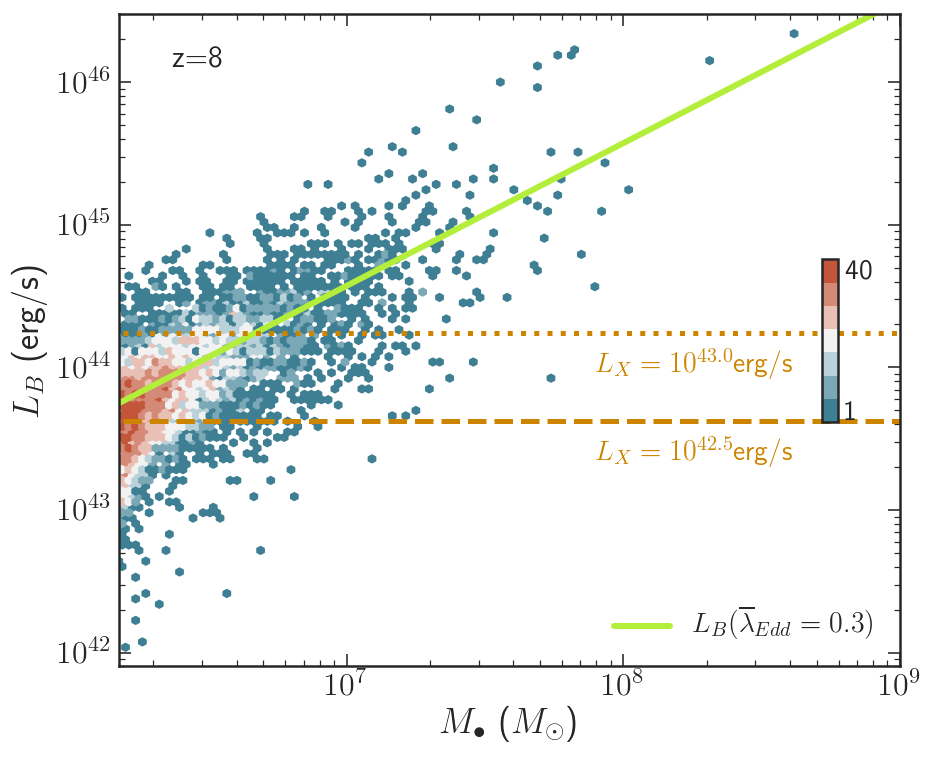

In [17]:
plot_bolometric_bhmass( accretionrate[0], blackholemass[0], bhlowercut )
savefig( 'BolometricL.eps', bbox_inches='tight', format='eps', dpi=2000 )

# BH mass function

In [18]:
def get_bhmf( accretionrate, blackholemass, bhlowercut, Lx_cut=-1 ):
    
    # select data above bh mass cut
    if Lx_cut>0:
        accretionrate = select_data_cut( accretionrate, blackholemass, bhlowercut, 1 )
        blackholemass = select_data_cut( blackholemass, blackholemass, bhlowercut, 1 )
        Lbol = acc_rate_to_bolometric(accretionrate)   # get bh bolometric luminosity
        blackholemass = select_data_cut( blackholemass, Lbol, get_Lbol_Marconi_correction(Lx_cut), 1 )
    elif Lx_cut==-1:
        blackholemass = select_data_cut( blackholemass, blackholemass, bhlowercut, 1 )

    xi = np.log10(bhlowercut)
    xf = 9
#     xi = np.log10( min(blackholemass) )
#     xf = np.log10( max(blackholemass) )
    xn = 12
        
    massbin   = np.logspace( xi, xf, xn, endpoint=True )
    massbinid = np.digitize( blackholemass, massbin )
    nofm  = np.bincount( massbinid, minlength = len(massbin)+1 ).astype(float64)
    nofm /= (400.0/h)**3
    
    dn    = np.diff(nofm)[:-1] 
    dlogm = np.diff(massbin)
    MF = np.abs( dn/dlogm )*massbin[:-1] 

    MB = massbin[:-1] 
    
    con = MF>0
    MB = MB[con]
    MF = MF[con]
    nofm = nofm[:-2][con]
    
    return MB, MF, nofm*(400.0/h)**3

In [19]:
def plot_Stark_bhmf():
    x = np.array([2e7, 6e7, 2e8])
    y = np.array([1e-4, 3e-5, 3e-6])

    loglog( x, y, 'sr' )

    plt.annotate( 'z=6',  xy=(1e7, 3e-5), xytext=(1e7, 4e-5), color='r', fontsize=annotate)    
    plt.annotate( 'Stark 2009',  xy=(1e7, 3e-5), xytext=(1e7, 2e-5), color='r', fontsize=annotate)
#     plt.annotate( '+ Volonteri 2011',  xy=(1e7, 3e-5), xytext=(1e7, 1.2e-5), color='r', fontsize=annotate)

In [20]:
def plot_Willott_bhmf():
    x  = logspace(7,9,8)
    ys = 1.23e-8
    Ms = 2.24e9
    aa = -1.03
    y  = ys*np.power(x/Ms, aa)*np.exp(-x/Ms)

    loglog( x, y, ':m' )
    
    plt.annotate( 'Willott 2010',  xy=(1e7, 3e-5), xytext=(1.8e8, 3e-7), color='m', fontsize=annotate)
    plt.annotate( 'z=6',  xy=(1e7, 3e-5), xytext=(4.5e8, 1.5e-7), color='m', fontsize=annotate)

In [21]:
def plot_bhmf(bhmfs, style, label=1):
    MBs = bhmfs[:,0]
    MFs = bhmfs[:,1]
    n_m = bhmfs[:,2]
    
    colors = [(0.2,0.5,0.9),(0.9,0.9,0.2),(0.5,0.9,0.5),(0.2,0.9,0.9),(0.9,0.5,0.2)]
    
    labels = ['z=08','z=09','z=10','z=11','z=12']
    for uu in range(0,5):
        if label==1:
            loglog( MBs[uu], MFs[uu], style, c=colors[uu], label=labels[uu] ) 
#             err = MFs[uu]/np.sqrt(MBs[uu]*MFs[uu])
            err = MFs[uu]/np.sqrt(np.pi*n_m[uu])
            
#             if uu==0:
#                 print MFs[uu]
#                 print err
            plt.fill_between( MBs[uu], MFs[uu]-err, MFs[uu]+err, alpha=0.3, edgecolor=colors[uu], facecolor=colors[uu] )

        elif label==0:
            loglog( MBs[uu], MFs[uu], style, c=colors[uu] ) 

In [22]:
def complete_bhmf():
    
    basic_fig_set()   # basic set of sns and fig
    
    bhmfs = np.array([get_bhmf( accretionrate[uu], blackholemass[uu], bhlowercut, 
                               Lx_cut=Lx_arr[1] ) for uu in range(0,5)])   # bhmd cut Lx[1]
    plot_bhmf(bhmfs, ':', label=0)
    
    bhmfs = np.array([get_bhmf( accretionrate[uu], blackholemass[uu], bhlowercut, 
                               Lx_cut=Lx_arr[0] ) for uu in range(0,5)])   # bhmd cut Lx[0]
    plot_bhmf(bhmfs, '--', label=0)

    bhmfs = np.array([get_bhmf( accretionrate[uu], blackholemass[uu], bhlowercut ) 
                      for uu in range(0,5)])   # get bhmf without Lx cut
    plot_bhmf(bhmfs, 'o-')
   
    plot_Willott_bhmf()
    plot_Stark_bhmf()
    
    ylabel(r'$dn/dlog(M_{\bullet})$ ($Mpc^{-3}$)', fontsize=labelfontsize)
    xlabel(r'$M_{\bullet}$ ($M_\odot$)', fontsize=labelfontsize)
    xlim(1e6,1e9)
    ylim(1e-8,1e-4)
    xticks([1e6,1e7,1e8,1e9],fontsize=tickfontsize)
    yticks([1e-8,1e-7,1e-6,1e-5,1e-4],fontsize=tickfontsize)

    plt.tick_params( which='both', top='on', right='on')
    plt.legend(loc=1, prop={'size':14})

# Right panel of fig 1 in paper 

/home/kuanweih/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]


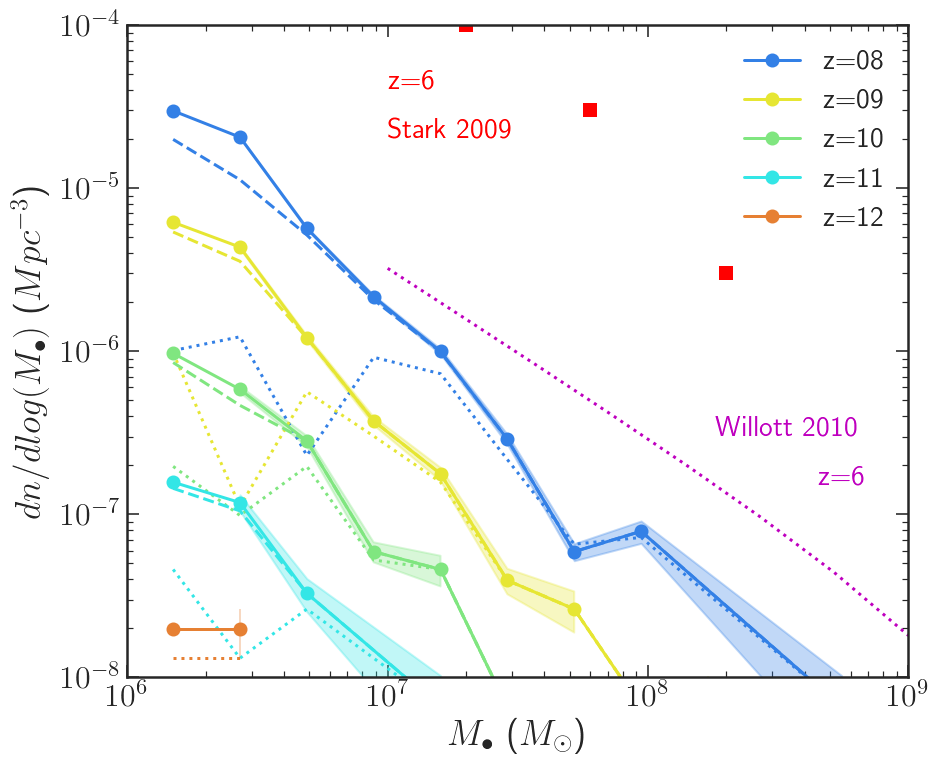

In [23]:
complete_bhmf()
savefig('BHMassFunction.pdf', bbox_inches='tight', dpi=2000)

# BHMD and SMD

In [24]:
annotate = 13

In [25]:
def get_massdensity( mass, lowercut ): 
    mass = select_data_cut( mass, mass, lowercut, 1 )
    density = np.sum(mass)/V
    return density

In [26]:
def basic_fig_set2():
    sns.set_style("white")
    sns.set_style("ticks",{"xtick.direction": "in","ytick.direction": "in"})
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(7, 7, forward=True)
    plt.subplots_adjust(hspace=0)

In [27]:
def get_BHMD_schecter(aa,ms,ns,mm,sc_slope,sc_norm):
    
    mm = 10**( (np.log10(mm) - sc_norm)/sc_slope )
    
    GSMF = 10**ns/10**ms * (mm/(10**ms))**aa * np.exp(-(mm/(10**ms))) * mm
    BHMF = GSMF/sc_slope
    
    mm = 10**(sc_norm + sc_slope*np.log10(mm))
    
    BHMD = np.trapz(BHMF,x=mm)
    
    return BHMD

In [28]:
def plot_Volonteri_2016():
    
    # GSMF in Grazian 2015 from z=4 to z=7
    aa = np.array([ -1.63, -1.63, -1.55, -1.88 ])
    ms = np.array([ 10.96, 10.78, 10.49, 10.69 ])
    ns = np.array([ -3.94, -4.18, -4.16, -5.24 ])
    mm = logspace(5,9)
    
    z_obser = range(4,8)

    BHMD_hm = np.array([get_BHMD_schecter(aa[uu],ms[uu],ns[uu],mm,1.4,-6.45) for uu in range(0,4)])
    BHMD_lm = np.array([get_BHMD_schecter(aa[uu],ms[uu],ns[uu],mm,1.05,-4.1) for uu in range(0,4)])
    
    plt.fill_between( z_obser, BHMD_lm, BHMD_hm, alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF' )
    plt.annotate( 'Volonteri 2016',  xy=(z_obser[0], BHMD_hm[0]), color='#1B2ACC',
                  xytext=(z_obser[0]*1.1, BHMD_hm[0]*0.3), fontsize=annotate)
    plt.yscale('log')

In [29]:
def plot_obs_massdensity():
    z_obser = range(4,8)

    # SMD Grazian 2015
    SMD_Grazian = np.array( [ 10**7.36, 10**6.93, 10**6.59, 10**6.04 ] )
    err_u = np.array( [ 10**7.39, 10**6.98, 10**6.64, 10**6.41 ] ) - SMD_Grazian
    err_d = SMD_Grazian - np.array( [ 10**7.34, 10**6.89, 10**6.52, 10**5.88 ] )
    plt.errorbar( z_obser, SMD_Grazian, yerr=[err_d,err_u], fmt='*', color='orange', ecolor='orange', markersize=7 )
    plt.annotate( 'SMD: Grazian 2015',  xy=(z_obser[0], SMD_Grazian[0]), xytext=(z_obser[0]*1.3, SMD_Grazian[0]*0.8), color='darkorange', fontsize=annotate)
    plt.yscale('log')
        
    # XRB upper limits
    plt.semilogy( [5,6,7,8], [6.6e3,6.6e3,6.6e3,6.6e3], 'd', markersize=6, color='peru' )
    plt.semilogy( [6,7,8], [851,666,674], 'v', markersize=6, color='slategrey' )
    plt.annotate( 'Salvaterra 2012 (XRB)',  xy=(6, 3e3), xytext=(4.4, 1.6e3), color='peru', fontsize=annotate)
    plt.annotate( 'Treister 2013',  xy=(6, 3e3), xytext=(4.4, 2e2), color='slategrey', fontsize=annotate)
    
    plt.annotate( 'BHMD:',  xy=(z_obser[0], SMD_Grazian[0]), color='k',
                  xytext=(z_obser[0]*1.093, SMD_Grazian[0]*5e-3), fontsize=annotate )

In [30]:
def plot_massdensity():
    z_arr = np.array( range(8,13) )
    
    # plot SMD 
    SMDens = np.array([get_massdensity( stellarmass[uu], 1e8 ) for uu in range(0,5)])
    semilogy( z_arr, SMDens, '-s', linewidth=2.5, c=(0.1,0.4,0.8) )
    
    plt.annotate( 'SMD: BlueTides',  xy=(z_arr[0], SMDens[0]), color=(0.1,0.4,0.8), 
                  xytext=(z_arr[0]*1.15, SMDens[0]*0.5), fontsize=annotate)

    # plot BHMD with BH mass > bhlowercut
    BHDens = np.array([get_massdensity( blackholemass[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, BHDens, '-o', linewidth=2.5, color='orangered', 
              label=r'$M_{\bullet} > 1.5\times10^6 M_{\odot}$'  )
    
    plt.annotate( 'BHMD:',  xy=(z_arr[0], BHDens[0]), 
                  xytext=(z_arr[0]*1.15, BHDens[0]*0.5), color='k', fontsize=annotate)
    plt.annotate( 'BlueTides',  xy=(z_arr[0], BHDens[0]), 
                  xytext=(z_arr[0]*1.25, BHDens[0]*0.1), color='k', fontsize=annotate)
    
    # plot BHMD with Lx > Lx_arr[0]
    blackholemass_Lx = np.array([select_data_cut( blackholemass[uu], 
                       acc_rate_to_bolometric(accretionrate[uu]), 
                       get_Lbol_Marconi_correction(Lx_arr[1]), 1 ) for uu in range(0,5)])
    BHDens = np.array([get_massdensity( blackholemass_Lx[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, BHDens, '--o', linewidth=2.5, color='orangered', 
              label=r'$L_X > 10^{%.1f}erg/s$' %np.log10(Lx_arr[1]) )
    
    # plot BHMD with BH mass > 1e7 Msun
    BHDens = np.array([get_massdensity( blackholemass[uu], 1e7 ) for uu in range(0,5)])
    semilogy( z_arr, BHDens, '-.o', linewidth=2.5, color='g', 
              label=r'$M_{\bullet} > 10^7 M_{\odot}$' )

In [31]:
def plot_ratio_massdensity():
    z_arr = np.array( range(8,13) )
    SMDens = np.array([get_massdensity( stellarmass[uu], 1e8 ) for uu in range(0,5)])
    BHDens = np.array([get_massdensity( blackholemass[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, SMDens/BHDens, '-P', markersize=6, c=(0.4,0.8,0.1), label='SMD/BHMD: BlueTides' )
    get_fit_ratio_massdensity(z_arr, SMDens/BHDens)

In [32]:
def func_ratio(z, a, b):   # Fitting function
    return a*(1+z)**b

In [33]:
def get_fit_ratio_massdensity(z_arr, ratio):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func_ratio, z_arr, ratio, maxfev=1000)
#     plot(z_arr, ratio)
#     plot(z_arr, func_ratio(z_arr, *popt), 'r-', label='fit')
    print('normalization = %.1f' %popt[0])
    print('power of (1+z) = %.1f' %popt[1])

In [34]:
def complete_massdensity():
    
    basic_fig_set2()
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
 
    plt.subplot(gs[0])   # top panel
    # ------------------------------------------------------------
    plot_massdensity()
    plot_Volonteri_2016()
    plot_obs_massdensity()
    
    plt.ylim(1e-1,1e8)
    plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8], fontsize=tickfontsize)

    plt.ylabel(r'SMD \& BHMD ($M_\odot / Mpc^3$)', fontsize=labelfontsize)
    plt.xticks([5,6,7,8,9,10,11])
    plt.tick_params( which='both', top='on', right='on', labelbottom='off')
    plt.legend(loc=3, fontsize=14)
    
    plt.subplot(gs[1], sharex = plt.subplot(gs[0]))   # bottom panel
    # ------------------------------------------------------------
    plot_ratio_massdensity()
    
    plt.tick_params( which='both', top='on', right='on', labelbottom='on')
    plt.legend(loc=2, fontsize=14)
    plt.xticks([4,5,6,7,8,9,10,11,12], fontsize=tickfontsize)
    plt.ylim(5e2,2e4)
    plt.ylabel('ratio', fontsize=labelfontsize)
    plt.yticks([1e3,1e4], fontsize=tickfontsize)
    plt.xlabel('z',fontsize=labelfontsize)

# Left panel of fig 2

/home/kuanweih/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


normalization = 1.3
power of (1+z) = 3.1


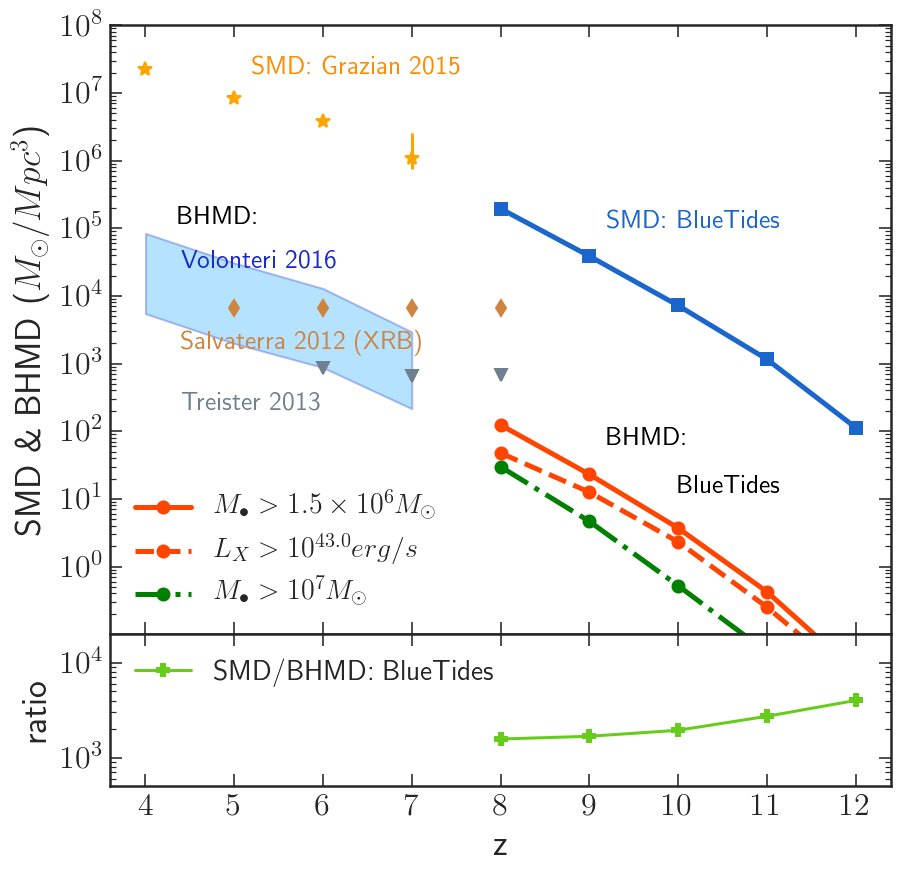

In [35]:
complete_massdensity()
savefig('SMD_BHMD.pdf', bbox_inches='tight', format='pdf', dpi=2000)

# BHAD and SFRD

In [36]:
def get_massratedensity( rate, mass, lowercut ): 
    rate = select_data_cut( rate, mass, lowercut, 1 )
    density = np.sum(rate)/V
    return density

In [37]:
def plot_massratedensity():
    z_arr = np.array( range(8,13) )
    
    # plot SFRD
    SFRDens = np.array([get_massratedensity( sfr[uu], stellarmass[uu], 1e8 ) for uu in range(0,5)])
    semilogy( z_arr, SFRDens, '-s', linewidth=2.5, c=(0.1,0.4,0.8) )
    plt.annotate( 'SFRD: BlueTides',  xy=(z_arr[0], SFRDens[0]), xytext=(z_arr[0]*1.17, SFRDens[0]*0.5), 
                  color=(0.1,0.4,0.8), fontsize=annotate)

    # plot BHAD with BH mass > bhlowercut
    BHADens = np.array([get_massratedensity( accretionrate[uu], blackholemass[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, BHADens, '-o', linewidth=2.5, color='orangered', 
              label=r'$M_{\bullet} > 1.5\times10^6 M_{\odot}$'  )
    plt.annotate( 'BHAD:',  xy=(z_arr[0], BHADens[0]), 
                  xytext=(z_arr[0]*1.2, BHADens[0]*0.5), color='k', fontsize=annotate)
    plt.annotate( 'BlueTides',  xy=(z_arr[0], BHADens[0]), 
                  xytext=(z_arr[0]*1.3, BHADens[0]*0.1), color='k', fontsize=annotate)
    
    # plot BHAD with Lx > Lx_arr[0]
    blackholemass_Lx = np.array([select_data_cut( blackholemass[uu], 
                       acc_rate_to_bolometric(accretionrate[uu]), 
                       get_Lbol_Marconi_correction(Lx_arr[1]), 1 ) for uu in range(0,5)])
    accretionrate_Lx = np.array([select_data_cut( accretionrate[uu], 
                       acc_rate_to_bolometric(accretionrate[uu]), 
                       get_Lbol_Marconi_correction(Lx_arr[1]), 1 ) for uu in range(0,5)])
    BHADens = np.array([get_massratedensity( accretionrate_Lx[uu],  blackholemass_Lx[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, BHADens, '--o', linewidth=2.5, color='orangered', 
              label=r'$L_X > 10^{%.1f}erg/s$' %np.log10(Lx_arr[1]) )
    
    # plot BHAD with BH mass > 1e7 Msun
    BHADens = np.array([get_massratedensity( accretionrate[uu], blackholemass[uu], 1e7 ) for uu in range(0,5)])
    semilogy( z_arr, BHADens, '-.o', linewidth=2.5, color='g', 
              label=r'$M_{\bullet} > 10^7 M_{\odot}$' )

In [38]:
def plot_obs_massratedensity():
    
    # SFRD Vito 2016
    z_vito = np.array( range(4,7) )
    SFRD_vito = np.array([ 3.2, 2.2, 1.3 ])*1e-2
    plt.annotate( 'SFRD: Vito 2016',  xy=(z_vito[0], SFRD_vito[0]), color='darkorange', 
                  xytext=(z_vito[0]*1.0, SFRD_vito[0]*0.08), fontsize=annotate)
    err_u = np.array( [ 0.3, 0.3, 0.2 ] )*1e-2
    err_d = np.array( [ 0.3, 0.3, 0.2 ] )*1e-2
    plt.errorbar( z_vito, SFRD_vito, yerr=[err_d,err_u], fmt='*', color='orange', ecolor='orange')

    # BHAD Sijacki 2015
    z_sijacki = np.array( [ 4, 5, 6, 7 ] )
    y_sijacki = np.array( [ 1.2e-4, 4e-5, 1e-5, 2e-6 ] )
    plt.semilogy( z_sijacki, y_sijacki, ':', markersize=6, color='purple' )
    plt.annotate( 'Sijacki 2015',  xy=(6, 3e-5), xytext=(5.4, 6e-5), color='purple', fontsize=annotate)
    plt.annotate( 'BHAD:',  xy=(6, 3e-5), xytext=(4, 2.2e-4), color='k', fontsize=annotate)
    
    #BHAD Vito 2017
    z_vito = np.array([ 3.78, 4.96, 5.86 ])
    BHAD_vito = np.array([ 8e-6, 1.2e-6, 7.5e-7 ])
    plt.annotate( 'Vito 2017',  xy=(4, 3e-5), xytext=(4, 1.5e-7), color='g', fontsize=annotate)
    err_u = np.array( [ 1.2e-5, 1.8e-6, 1.1e-6 ] ) - BHAD_vito
    err_d = BHAD_vito - np.array( [ 5.3e-6, 8.5e-7,   5e-7 ] )
    err_l = z_vito - np.array( [ 3.5, 4.5, 5.5 ] )
    err_r = np.array( [ 4.5, 5.5, 6.0 ] ) - z_vito
    plt.errorbar( z_vito, BHAD_vito, xerr=[err_l,err_r], yerr=[err_d,err_u], fmt='.', color='g', ecolor='g')

In [39]:
def plot_ratio_massratedensity():
    z_arr = np.array( range(8,13) )
    SFRDens = np.array([get_massratedensity( sfr[uu], stellarmass[uu], 1e8 ) for uu in range(0,5)])
    BHADens = np.array([get_massratedensity( accretionrate[uu], blackholemass[uu], bhlowercut ) for uu in range(0,5)])
    semilogy( z_arr, SFRDens/BHADens, '-P', markersize=6, c=(0.4,0.8,0.1), label='SFRD/BHAD: BlueTides' )
    get_fit_ratio_massdensity(z_arr, SFRDens/BHADens)

In [40]:
def complete_massratedensity():
    
    basic_fig_set2()
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
 
    plt.subplot(gs[0])   # top panel
    # ------------------------------------------------------------
    plot_massratedensity()
    plot_obs_massratedensity()

    plt.yticks([1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], fontsize=16)
     
#     plt.yticks([1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], 
#            ['$10^{-9}$',' ','$10^{-7}$',' ','$10^{-5}$',' ','$10^{-3}$',' ','$10^{-1}$'], fontsize=16)
    plt.ylabel(r'SFRD \& BHAD ($ M_{\odot} / yr / Mpc^3 $)', fontsize=18)
    plt.xticks([5,6,7,8,9,10,11])
    plt.tick_params( which='both', top='on', right='on', labelbottom='off')
    plt.legend(loc=3, fontsize=14)
    
    plt.subplot(gs[1], sharex = plt.subplot(gs[0]))   # bottom panel
    # ------------------------------------------------------------
    plot_ratio_massratedensity()
    
    plt.tick_params( which='both', top='on', right='on', labelbottom='on')
    plt.legend(loc=2, fontsize=14)
    plt.xticks([4,5,6,7,8,9,10,11,12], fontsize=tickfontsize)
    plt.ylim(5e2,2e4)
    plt.ylabel('ratio', fontsize=labelfontsize)
    plt.yticks([1e3,1e4], fontsize=tickfontsize)
    plt.xlabel('z',fontsize=labelfontsize)

# Right panel of fig 2

normalization = 3.4
power of (1+z) = 2.7


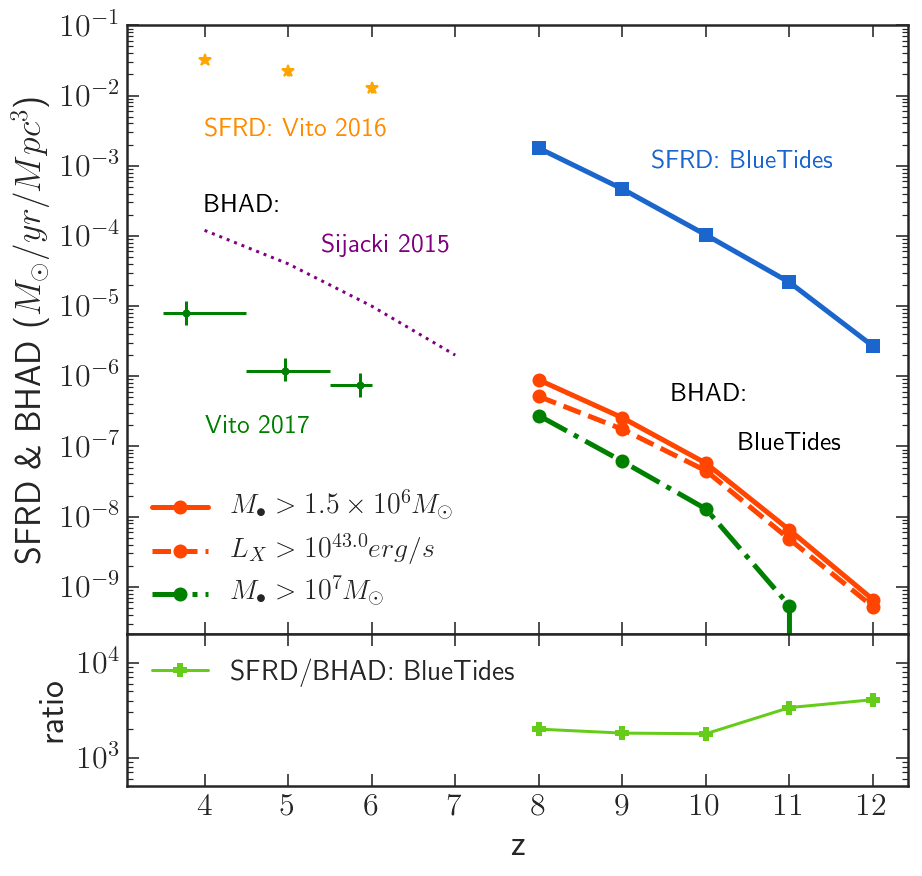

In [41]:
complete_massratedensity()
savefig('SFRD_BHARD.eps', bbox_inches='tight', format='eps', dpi=2000)